In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
#jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tornadox

from pof.solve import get_solver_iterator

In [3]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e0, tmax=128)
ivp.y0.device()

GpuDevice(id=0, process_index=0)

In [4]:
dt = 1e-2
order = 3

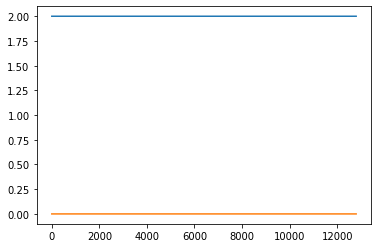

In [5]:
init_state, refine, project = get_solver_iterator(ivp, order=order, dt=dt, parallel=False)
plt.plot(project(init_state))

In [6]:
refine_jit_gpu = jax.jit(refine, backend="gpu")
refine_jit_cpu = jax.jit(refine, backend="cpu")

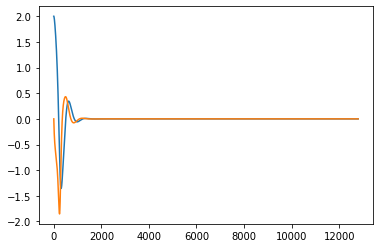

In [7]:
state = init_state
for _ in range(40):
    state = refine_jit_cpu(state)
plt.plot(project(state))

# Benchmarks

In [8]:
#%%timeit
# unjitted GPU
#refine(state).mean.block_until_ready()

In [9]:
# %%timeit
# refine_jit_gpu(state).mean.block_until_ready()

In [10]:
%%timeit
refine_jit_cpu(state).mean.block_until_ready()
# note that this number might even include moving data to the cpu

468 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
_, refine_par, _ = get_solver_iterator(ivp, order=order, dt=dt, parallel=True)

In [12]:
#%%timeit
#refine_par(state).mean.block_until_ready()

In [13]:
refine_par_jit_gpu = jax.jit(refine_par, backend="gpu")
#refine_par_jit_cpu = jax.jit(refine_par, backend="cpu")
refine_par_jit_gpu(state).mean.block_until_ready();

In [14]:
%%timeit
refine_par_jit_gpu(state).mean.block_until_ready()

677 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
#%%timeit
#refine_par_jit_cpu(state).mean.block_until_ready()
# this one sucks